# 雑草の生育期間を区別せずに分類器を作る（10種類）
　雑草の生育期間（芽生え・生育済み）を区別せずに分類器を作成します。 育成した雑草の種類はハキダメギク、ホソアオゲイトウ、イチビ、イヌビエ、コセンダングサ、マメアサガオ、メヒシバ、オヒシバ、オイヌタデ、シロザの10種類です

### ■データのダウンロード

・cluster.zipをダウンロードします。

In [0]:
#グーグルドライブからファイルをダウンロードする方法
#ファイル限定

import requests

def download_file_from_google_drive(id, destination):

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)

    token = get_confirm_token(response)

    if token:

        params = { 'id' : id, 'confirm' : token }

        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):

    for key, value in response.cookies.items():

        if key.startswith('download_warning'):

            return value

    return None

def save_response_content(response, destination):

    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:

        for chunk in response.iter_content(CHUNK_SIZE):

            if chunk: # filter out keep-alive new chunks

                f.write(chunk)

#取得されるトークン
file_id = '1XillhpofzGUFJwQ_CvXpsWDuWT0lp2-w'

#欲しいフォルダ名
destination = 'cluster.zip'

download_file_from_google_drive(file_id, destination)



・cluster.zipを解凍します。

In [0]:
!unzip cluster
print("clusterファイルの解凍が完了しました。")

### ■データセットの作成

・train、validation、prediction用のディレクトリを作成し、class用のディレクトリを追加します

In [3]:
import os, shutil

# CLSディレクトリを作成します
base_dir = "./CLS"
if "CLS" not in os.listdir("./"):
  os.mkdir(base_dir)
else:
  print(base_dir, "は既に存在します")

# train用ディレクトリを作成します
train_index = "train"
train_dir = os.path.join(base_dir, train_index)
if train_index not in os.listdir(base_dir):
  os.mkdir(train_dir)
else:
  print(train_dir + "は既に存在します")

# validation用ディレクトリを作成します
validation_index = "validation"
validation_dir = os.path.join(base_dir, validation_index)
if validation_index not in os.listdir(base_dir):
  os.mkdir(validation_dir)
else:
  print(validation_dir + "は既に存在します")

# prediction用ディレクトリを作成します
prediction_index = "prediction"
prediction_dir = os.path.join(base_dir, prediction_index)
if prediction_index not in os.listdir(base_dir):
  os.mkdir(prediction_dir)
else:
  print(prediction_dir + "は既に存在します")

#class用ディレクトリを作成します
classes=["hakidamegiku","hosoaogeitou","ichibi",
         "inubie","kosendangusa","mameasagao",
         "mehishiba","ohishiba","oinutade","shiroza",]
dirs = os.listdir(base_dir)
for dir in dirs:
  for cls in classes:
    # Directory with our training pictures
    class_dir = os.path.join(base_dir, dir, cls)
    if cls not in os.listdir(base_dir + "/" + dir):
      os.mkdir(class_dir)
    else:
      print(class_dir, "は既に存在します")

print("作成完了！")

作成完了！


・画像をディレクトリに振り分けます。

In [0]:
from os.path import join
import random

clsdir = "./cluster"
base_dir = "./CLS"
dirs = os.listdir(base_dir)
weed_types = ["sprout","grown"]
weed_names = os.listdir(clsdir)
# ファイル（クラスごとに分かれている）を順番に読み取り
# train, validationデータを作成
for weed_name in weed_names:
  for weed_type in weed_types: 
    print(weed_name, "/",weed_type)
    # 画像をランダムに抽出
    file_names = os.listdir(os.path.join(clsdir, weed_name, weed_type))
    files100 = random.sample(file_names, int(100))
    num1 = 0
    num2 = 0
    for file_name in file_names:
      if  file_name in files100:
        if num1 >= 90:
          continue
        # 移動元のファイル
        path1 = os.path.join(clsdir, weed_name, weed_type, file_name)
        # 移動先のファイル
        path2= os.path.join(base_dir, "train", weed_name, file_name)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))
        num1 = num1 + 1
      else:
        if num2 >= 90:
          continue 
        # 移動元のファイル
        path1 = os.path.join(clsdir, weed_name, weed_type, file_name)
        # 移動先のファイル
        path2= os.path.join(base_dir, "validation", weed_name, file_name)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))
        num2 = num2 + 1

# predictionデータを作成
for weed_name in weed_names:
  for weed_type in weed_types:
    print(weed_name, "/",weed_type)
    file_names = os.listdir(os.path.join(clsdir, weed_name, weed_type))
    for file_name in file_names:      
      # 移動元のファイル
      path1 = os.path.join(clsdir, weed_name, weed_type, file_name)
      # 移動先のファイル
      path2= os.path.join(base_dir, "prediction", weed_name, file_name)
      # ファイルを移動
      new_path = shutil.move(path1, path2)
      # ファイルの存在確認
      print(os.path.exists(path2))


・trainデータ、validationデータ、predictionデータのgeneratorを作成します

In [5]:
import os 
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import keras.preprocessing.image as Image

input_size = 224

train_dir = "./CLS/train"
validation_dir = "./CLS/validation"
prediction_dir = "./CLS/prediction"


train_datagen = Image.ImageDataGenerator(
            featurewise_center = False,
            samplewise_center = False,
            featurewise_std_normalization = False,
            samplewise_std_normalization = False,
            zca_whitening = False,
            rotation_range = 90,
            width_shift_range = 0.3,
            height_shift_range = 0.3,
            horizontal_flip = True,
            vertical_flip = False,
            rescale=1./255
        )

val_datagen = Image.ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(input_size,input_size),
            batch_size=10,
            class_mode='categorical'
        )

validation_generator = val_datagen.flow_from_directory(
            validation_dir,
            target_size=(input_size,input_size),
            batch_size=10,
            class_mode='categorical'
        )
print("データセット作成完了！")

Using TensorFlow backend.


Found 1800 images belonging to 10 classes.
Found 1800 images belonging to 10 classes.
データセット作成完了！


### ■トレーニングの実行

・モデルのレイヤー構成を定義します

In [0]:

#ファインチューニング+VGG+水増し。ここから実行してOK（VGG16をダウンロード）
from keras import models
from keras import layers
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.applications import VGG16
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History, Callback
from keras.objectives import categorical_crossentropy
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.utils import to_categorical
from scipy.stats import mode
import os, pickle
from sklearn.metrics import classification_report, confusion_matrix


def create_cnn():
  input_size=224
  #input_sizeは224,224までOK。

  vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(input_size,input_size, 3))
  last = vgg_conv.output

  vgg_conv.trainable = True

  set_trainable = False
  for layer in vgg_conv.layers:
    if layer.name == 'block5_conv1':
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False

  mod = Flatten()(last)
  mod = Dense(256, activation='relu')(mod)
  #mod = Dropout(0.5)(mod)
  preds = Dense(10, activation='softmax')(mod)

  model = models.Model(vgg_conv.input, preds)

  return model


・チェックポイントを定義します(val lossが一番低い値の時にweightファイルを保存)

In [0]:
class Checkpoint(Callback):
    def __init__(self, model, filepath):
        self.model = model
        self.filepath = filepath
        self.best_val_acc = 0.0
        self.best_val_loss = 0.5

    def on_epoch_end(self, epoch, logs):
        # val_lossが最小の時ににweightを保存する
        if self.best_val_loss > logs["val_loss"]:
            self.model.save_weights(self.filepath)
            self.best_val_loss = logs["val_loss"]
            print("Weights saved.", self.best_val_loss)

・学習の実行手順を定義します

In [0]:
def train():
    print("学習を開始します")
    hist = History()
    train_model = create_cnn()
    train_model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
    cp = Checkpoint(train_model, f"weights.hdf5")
    train_model.fit_generator(train_generator,epochs=10,validation_data=validation_generator,callbacks=[hist, cp])      
    print("学習が完了しました")
    return hist.history


・学習を開始します

In [9]:
K.clear_session()
hist = train()

学習を開始します
58892288/58889256 [==============================] - 2s 0us/step
Epoch 1/10
180/180 [==============================] - 44s 244ms/step - loss: 1.8960 - accuracy: 0.3150 - val_loss: 1.3553 - val_accuracy: 0.5644
Epoch 2/10
180/180 [==============================] - 36s 198ms/step - loss: 1.2428 - accuracy: 0.5433 - val_loss: 0.4719 - val_accuracy: 0.6761
Weights saved. 0.4719138741493225
Epoch 3/10
180/180 [==============================] - 36s 201ms/step - loss: 0.9683 - accuracy: 0.6539 - val_loss: 1.0652 - val_accuracy: 0.7283
Epoch 4/10
180/180 [==============================] - 36s 199ms/step - loss: 0.7921 - accuracy: 0.7200 - val_loss: 0.5009 - val_accuracy: 0.8011
Epoch 5/10
180/180 [==============================] - 36s 200ms/step - loss: 0.6573 - accuracy: 0.7772 - val_loss: 0.2948 - val_accuracy: 0.7961
Weights saved. 0.2947883903980255
Epoch 6/10
180/180 [==============================] - 36s 199ms/step - loss: 0.5804 - accuracy: 0.7956 - val_loss: 0.2512 - val_accur

### ■正解率と損失率をグラフ化

・trainの正解率と損失率、validationの正解率と損失率をグラフ化します

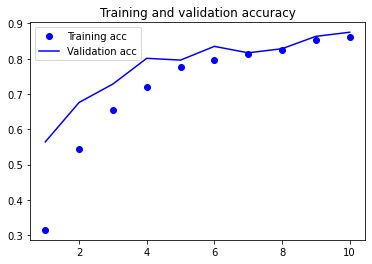

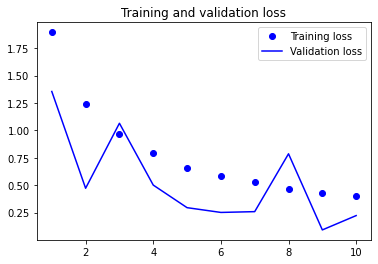

In [10]:
import matplotlib.pyplot as plt

history = hist

acc=history['accuracy']
val_acc=history['val_accuracy']
loss=history['loss']
val_loss=history['val_loss']

epochs=range(1,len(acc)+1)

#正解率plot
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


#損失値をplot
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


### ■推論

・prediction用のデータセットを作成します

In [11]:
from PIL import Image
import os, glob
import numpy as np
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES =True

prediction_dir = "./CLS/prediction"
prediction_classes = ["hakidamegiku","hosoaogeitou","ichibi","inubie","kosendangusa","mameasagao","mehishiba","ohishiba","oinutade","shiroza"]

# prediction_classes = os.listdir(prediction_dir)
image_size = 224
print(prediction_classes)
X_test = []
y_test = []
for index, classlabel in enumerate(prediction_classes):
    photos_dir = os.path.join(prediction_dir, classlabel)
    files = glob.glob(photos_dir + "/*.JPG")
    print(files)
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        if i == 0:
          print(data.shape)
        X_test.append(data)
        y_test.append(index)

X_test1 = np.array(X_test)
y_test1 = np.array(y_test)

['hakidamegiku', 'hosoaogeitou', 'ichibi', 'inubie', 'kosendangusa', 'mameasagao', 'mehishiba', 'ohishiba', 'oinutade', 'shiroza']
['./CLS/prediction/hakidamegiku/hakidamegiku_IMG_1774_7.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1652_10.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1773_10.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1524_13.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1524_19.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1807_4.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1547_15.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_4885_1.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_4463_3.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1574_18.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1596_14.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_4466_1.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1614_11.JPG', './CLS/prediction/hakidamegiku/hakidamegiku_IMG_1525_13.JPG', './CL

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=-90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



・保存したweightファイルをロードしてpredictionを行います

In [0]:
def sin_predict():
    
    X_test, y_test = X_test1, y_test1
    X_test = X_test / 255.0
    y_test_label = np.ravel(y_test)
    y_test = to_categorical(y_test)

    train_model = create_cnn()
    train_model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

    # 最良のモデルの読み込み
    train_model.load_weights(f"weights.hdf5")
    for layer in train_model.layers:
        layer.trainable = False

    # 単体の推論
    single_preds = np.argmax(train_model.predict(X_test), axis=-1)

    # 推論のスコア
    test_acc = accuracy_score(y_test, to_categorical(single_preds))
    

    print("推論の結果は", test_acc, "です")
    
    target_names = ["hakidamegiku","hosoaogeitou","ichibi","inubie","kosendangusa","mameasagao","mehishiba","ohishiba","oinutade","shiroza"]
    cm = confusion_matrix(y_test_label, single_preds)
    plot_confusion_matrix(cm, classes = target_names) 
    # print('Classification Report')
    # print(classification_report(y_test_label, single_preds, target_names=target_names))


・推論を実行します

推論の結果は 0.8575 です
Confusion matrix, without normalization


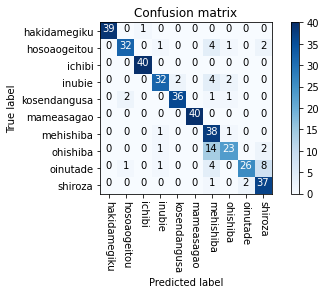

In [36]:
# 推論
sin_predict()

### ■任意の写真を推論します

・1枚の画像を推論する関数を定義します

In [0]:
def result_predict(path):
    prediction_classes = ["hakidamegiku","hosoaogeitou","ichibi","inubie","kosendangusa","mameasagao","mehishiba","ohishiba","oinutade","shiroza"]

    train_model = create_cnn()
    train_model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

    # 最良のモデルの読み込み
    train_model.load_weights(f"weights.hdf5")
    for layer in train_model.layers:
        layer.trainable = False  
    
    X_test = []
    image_size = 224
    image = Image.open(path)
    image = image.convert("RGB")
    image = image.resize((image_size, image_size))
    data = np.asarray(image)
    X_test.append(data)
    X_test = np.array(X_test)
    result = np.argmax(train_model.predict(X_test), axis=-1)
    print("雑草の種類は", prediction_classes[result[0]], "です")


任意の写真のpathを設定します

In [0]:
image_dir = "./CLS/prediction/ichibi/ichibi_IMG_4164_1.JPG"
result_predict(image_dir)

雑草の種類は ichibi です


In [0]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(validation_generator.classes, y_pred))